In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("creditcard.csv")   # Change path if needed
print(df.head())
print(df.info())
print(df.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

EDA (EXPLORATORY DATA ANALYSIS)


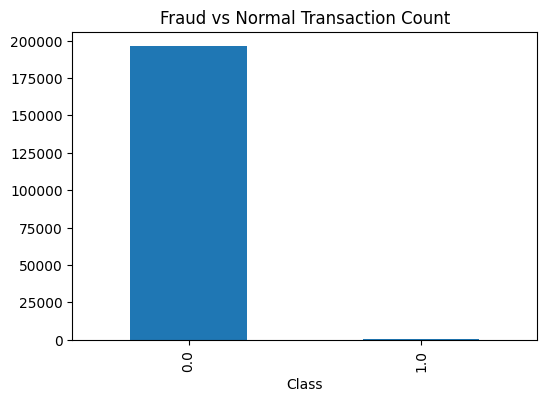

Fraud Ratio:
 Class
0.0    0.998056
1.0    0.001944
Name: proportion, dtype: float64


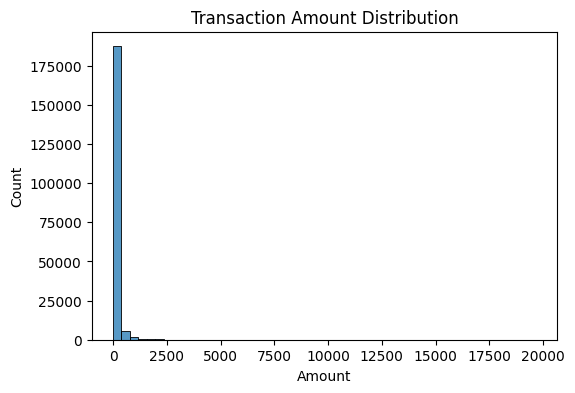

In [3]:
# Fraud ratio
plt.figure(figsize=(6,4))
df['Class'].value_counts().plot(kind='bar')
plt.title("Fraud vs Normal Transaction Count")
plt.show()

fraud_ratio = df['Class'].value_counts(normalize=True)
print("Fraud Ratio:\n", fraud_ratio)

# Distribution of Amount
plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=50)
plt.title("Transaction Amount Distribution")
plt.show()

# # Correlation Heatmap
# plt.figure(figsize=(15,8))
# sns.heatmap(df.corr(), cmap="coolwarm", center=0)
# plt.title("Correlation Heatmap")
# plt.show()


FEATURE ENGINEERING

In [7]:
df['Amount_log'] = np.log1p(df['Amount'])
df = df.dropna()


TRAIN-TEST SPLIT

In [8]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

HANDLE IMBALANCE (SMOTE)

In [9]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: Class
0.0    156881
1.0       306
Name: count, dtype: int64
After SMOTE: Class
0.0    156881
1.0    156881
Name: count, dtype: int64


NORMALIZATION

In [10]:
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

MODEL 1 — RANDOM FOREST

In [11]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42
)

rf.fit(X_train_res, y_train_res)
rf_pred = rf.predict(X_test)

print("\n===== RANDOM FOREST REPORT =====")
print(classification_report(y_test, rf_pred))
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_pred))


===== RANDOM FOREST REPORT =====
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     39221
         1.0       0.80      0.87      0.83        76

    accuracy                           1.00     39297
   macro avg       0.90      0.93      0.91     39297
weighted avg       1.00      1.00      1.00     39297

Accuracy: 0.9993129246507367
ROC-AUC: 0.9339938056814354


MODEL 2 — XGBOOST

In [12]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

xgb.fit(X_train_res, y_train_res)
xgb_pred = xgb.predict(X_test)

print("\n===== XGBOOST REPORT =====")
print(classification_report(y_test, xgb_pred))
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, xgb_pred))


===== XGBOOST REPORT =====
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     39221
         1.0       0.90      0.87      0.89        76

    accuracy                           1.00     39297
   macro avg       0.95      0.93      0.94     39297
weighted avg       1.00      1.00      1.00     39297

Accuracy: 0.9995673970023157
ROC-AUC: 0.9341212884075261


CONFUSION MATRIX (BEST MODEL)

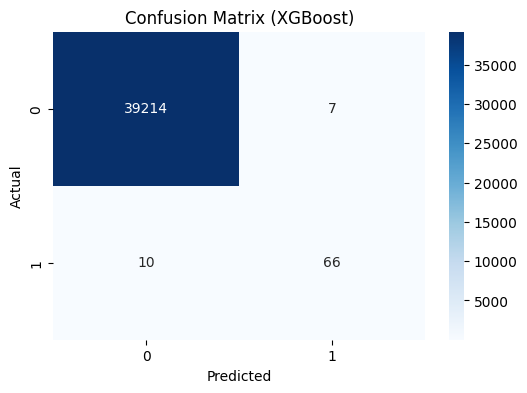

In [13]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

FINAL COMPARISON

In [14]:
print("\n========== FINAL RESULTS ==========")
print("RandomForest Accuracy:", accuracy_score(y_test, rf_pred))
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))

print("RandomForest AUC:", roc_auc_score(y_test, rf_pred))
print("XGBoost AUC:", roc_auc_score(y_test, xgb_pred))


========== FINAL RESULTS ==========
RandomForest Accuracy: 0.9993129246507367
XGBoost Accuracy: 0.9995673970023157
RandomForest AUC: 0.9339938056814354
XGBoost AUC: 0.9341212884075261
